In [1]:
# Imports

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score,
    precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score,
    classification_report, confusion_matrix,
    roc_curve, auc,
    hamming_loss
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler

from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb

RANDOM_STATE = 42

In [2]:
# Lecture du jeu de données

data_i = pd.read_csv("donnees-defi-egc.csv", sep=",", low_memory=False)
print("Shape:", data_i.shape)
display(data_i.head())

Shape: (15375, 34)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,CODE,CODE_PARENT,CODE_PARENT_DESC,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,...,TYPEIMPLANTATIONPLU,VARIETE,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,ESP33155,ESP385,R D Fontanelle ang Essen JO,10 à 20 cm,cordata,passages fréquents ou arrêts,...,?,?,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,?,ESP2079,ESP116,Crs Libération Beauvert Alliés,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,?,2014,ESP26205,ESP635,Pl R Frappat ang Eaux Claires,10 à 20 cm,grandiflora,passages fréquents ou arrêts,...,?,?,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,ESP7496,ESP109,R François Raoult,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,?,ESP2547,ESP194,Terminus Tram Esclangon,20 à 30 cm,americana,passages fréquents et arrêts fréquents,...,?,?,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


# Analyse exploratoire - Prétraitements

In [3]:
# Remplacer '?' par NaN + supprimer colonnes "quasi identifiants"

data_i = data_i.replace("?", np.nan)

data = data_i.drop(columns=[c for c in ['CODE', 'CODE_PARENT', 'CODE_PARENT_DESC', 'SOUS_CATEGORIE'] if c in data_i.columns])

print("Shape après drop cols:", data.shape)
display(data.head())

Shape après drop cols: (15375, 30)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,GENRE_BOTA,IDENTIFIANTPLU,INTITULEPROTECTIONPLU,...,TYPEIMPLANTATIONPLU,VARIETE,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,10 à 20 cm,cordata,passages fréquents ou arrêts,Alnus,NaN,NaN,...,NaN,NaN,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,NaN,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,Platanus,NaN,NaN,...,NaN,NaN,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,NaN,2014,10 à 20 cm,grandiflora,passages fréquents ou arrêts,Magnolia,NaN,NaN,...,NaN,NaN,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,Sophora,NaN,NaN,...,NaN,NaN,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,NaN,20 à 30 cm,americana,passages fréquents et arrêts fréquents,Fraxinus,NaN,NaN,...,NaN,NaN,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


In [5]:
# Listes num/cat + valeurs manquantes 

colonnes_numeriques = [c for c in data.columns if pd.api.types.is_numeric_dtype(data[c])]
colonnes_nominales = [c for c in data.columns if c not in colonnes_numeriques]

valeurs_manquantes = data.isnull().sum().sort_values(ascending=False)
pourcentage_manquant_par_colonne = (data.isnull().mean() * 100).round(2).sort_values(ascending=False)

print("Top colonnes manquantes:")
display(pd.DataFrame({
    "missing_count": valeurs_manquantes,
    "missing_%": pourcentage_manquant_par_colonne
}).head(20))

Top colonnes manquantes:


,missing_count,missing_%
RAISONDEPLANTATION,15145,98.50
INTITULEPROTECTIONPLU,15014,97.65
IDENTIFIANTPLU,15014,97.65
TYPEIMPLANTATIONPLU,15014,97.65
TRAITEMENTCHENILLES,14287,92.92
VARIETE,13212,85.93
REMARQUES,11176,72.69
TRAVAUXPRECONISESDIAG,4525,29.43
ANNEETRAVAUXPRECONISESDIAG,4511,29.34
ESPECE,1018,6.62


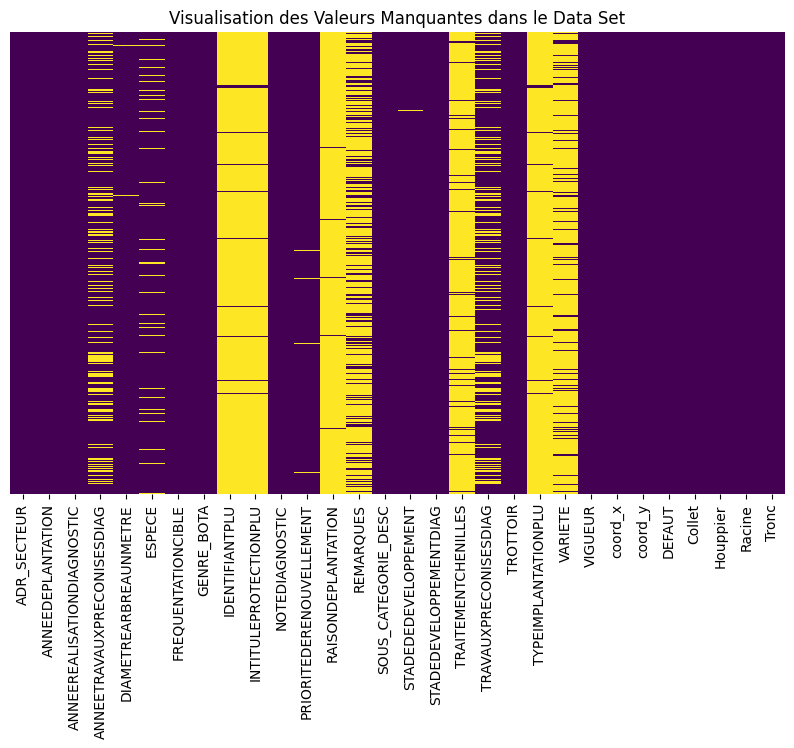

In [6]:
# Cellule 5 — Heatmap NA

plt.figure(figsize=(10, 6))
sns.heatmap(data.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.title('Visualisation des Valeurs Manquantes dans le Data Set')
plt.show()

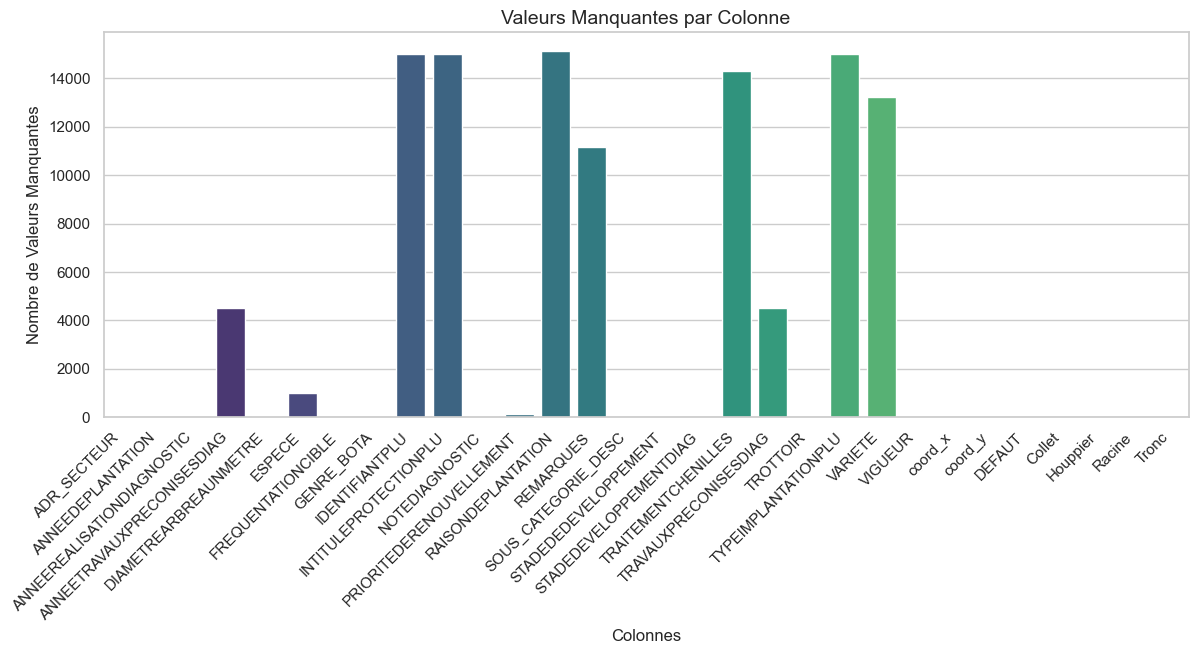

In [7]:
# Barplot NA 
valeurs_manquantes = data.isnull().sum()

sns.set(style='whitegrid')
plt.figure(figsize=(14, 5))
sns.barplot(x=valeurs_manquantes.index, y=valeurs_manquantes, palette='viridis')
plt.title('Valeurs Manquantes par Colonne', fontsize=14)
plt.xlabel('Colonnes', fontsize=12)
plt.ylabel('Nombre de Valeurs Manquantes', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.show()

In [8]:
# Supprimer colonnes >70% NA 

seuil_pourcentage = 70
seuil = len(data) * seuil_pourcentage / 100.0

data_new = data.dropna(axis=1, thresh=seuil)

print("Shape après suppression >70% NA:", data_new.shape)
display(data_new.head())
display(data_new.describe(include="all").T.head(20))

Shape après suppression >70% NA: (15375, 23)


,ADR_SECTEUR,ANNEEDEPLANTATION,ANNEEREALISATIONDIAGNOSTIC,ANNEETRAVAUXPRECONISESDIAG,DIAMETREARBREAUNMETRE,ESPECE,FREQUENTATIONCIBLE,GENRE_BOTA,NOTEDIAGNOSTIC,PRIORITEDERENOUVELLEMENT,...,TRAVAUXPRECONISESDIAG,TROTTOIR,VIGUEUR,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc
0,5,2014,2014,2019,10 à 20 cm,cordata,passages fréquents ou arrêts,Alnus,Arbre davenir normal,plus de 20 ans,...,Controle,non,vigoureux,1.915371e+06,4.222837e+06,0,0,0,0,0
1,3,2004,2013,NaN,30 à 40 cm,acerifolia,passages fréquents et arrêts fréquents,Platanus,Arbre davenir normal,plus de 20 ans,...,NaN,non,vigoureux,1.913250e+06,4.222531e+06,0,0,0,0,0
2,3,2004,NaN,2014,10 à 20 cm,grandiflora,passages fréquents ou arrêts,Magnolia,Arbre davenir normal,plus de 20 ans,...,Controle,oui,vigoureux,1.913087e+06,4.223524e+06,0,0,0,0,0
3,2,2004,2014,2014,40 à 50 cm,japonica,passages fréquents et arrêts fréquents,Sophora,Arbre davenir normal,plus de 20 ans,...,Taille mise en sécurité,oui,vigoureux,1.914187e+06,4.224275e+06,1,0,1,1,0
4,1,2004,2013,NaN,20 à 30 cm,americana,passages fréquents et arrêts fréquents,Fraxinus,Arbre davenir normal,plus de 20 ans,...,NaN,oui,vigoureux,1.912975e+06,4.225210e+06,0,0,0,0,0


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ADR_SECTEUR,15375.0,NaN,NaN,NaN,3.680455,1.678015,1.0,2.0,4.0,5.0,6.0
ANNEEDEPLANTATION,15375.0,NaN,NaN,NaN,2004.92761,2.604701,2004.0,2004.0,2004.0,2004.0,2015.0
ANNEEREALISATIONDIAGNOSTIC,15367,5,2015,6634,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ANNEETRAVAUXPRECONISESDIAG,10864,11,2014,2217,NaN,NaN,NaN,NaN,NaN,NaN,NaN
DIAMETREARBREAUNMETRE,15308,19,10 à 20 cm,4221,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ESPECE,14357,226,acerifolia,2864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FREQUENTATIONCIBLE,15374,3,passages fréquents et arrêts fréquents,12164,NaN,NaN,NaN,NaN,NaN,NaN,NaN
GENRE_BOTA,15375,107,Platanus,2982,NaN,NaN,NaN,NaN,NaN,NaN,NaN
NOTEDIAGNOSTIC,15335,5,Arbre davenir normal,11716,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PRIORITEDERENOUVELLEMENT,15248,4,plus de 20 ans,11371,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Une colonne avec >70% de valeurs manquantes contient très peu d’info exploitable : elle va surtout rajouter du bruit, et l’imputation deviendrait essentiellement du “remplissage au hasard”. À l’inverse, une colonne avec par ex. 10–40% de NA peut être très informative : on préfère la garder et imputer (médiane/mode, etc.).

#### on enlève les colonnes presque vides, mais on garde celles qui ont encore assez de signal.

In [9]:
#  Imputation "exploratoire" (pour EDA seulement)

data_numerique = data_new.select_dtypes(include='number')
data_catégorielles = data_new.select_dtypes(include='object')

data_numerique = data_numerique.apply(lambda col: col.fillna(col.mean()), axis=0)

if len(data_catégorielles.columns) > 0:
    data_catégorielles = data_catégorielles.fillna(data_catégorielles.mode().iloc[0])

print("NA numériques:", data_numerique.isnull().sum().sum())
print("NA catégorielles:", data_catégorielles.isnull().sum().sum() if len(data_catégorielles.columns) else 0)

NA numériques: 0
NA catégorielles: 0


In [10]:
# Label Encoding (comme ton notebook) - pour EDA / corr seulement

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

for col in data_catégorielles.columns:
    data_catégorielles[col] = label_encoder.fit_transform(data_catégorielles[col].astype(str))

resultat = pd.concat([data_numerique, data_catégorielles], axis=1)
print("Shape resultat:", resultat.shape)
display(resultat.head())

Shape resultat: (15375, 23)


,ADR_SECTEUR,ANNEEDEPLANTATION,coord_x,coord_y,DEFAUT,Collet,Houppier,Racine,Tronc,ANNEEREALISATIONDIAGNOSTIC,...,FREQUENTATIONCIBLE,GENRE_BOTA,NOTEDIAGNOSTIC,PRIORITEDERENOUVELLEMENT,SOUS_CATEGORIE_DESC,STADEDEDEVELOPPEMENT,STADEDEVELOPPEMENTDIAG,TRAVAUXPRECONISESDIAG,TROTTOIR,VIGUEUR
0,5,2014,1.915371e+06,4.222837e+06,0,0,0,0,0,3,...,1,5,1,3,0,1,1,3,0,1
1,3,2004,1.913250e+06,4.222531e+06,0,0,0,0,0,2,...,0,75,1,3,0,0,0,12,0,1
2,3,2004,1.913087e+06,4.223524e+06,0,0,0,0,0,4,...,1,59,1,3,2,0,0,3,1,1
3,2,2004,1.914187e+06,4.224275e+06,1,0,1,1,0,3,...,0,94,1,3,0,0,0,13,1,1
4,1,2004,1.912975e+06,4.225210e+06,0,0,0,0,0,2,...,0,41,1,3,0,0,0,12,1,1


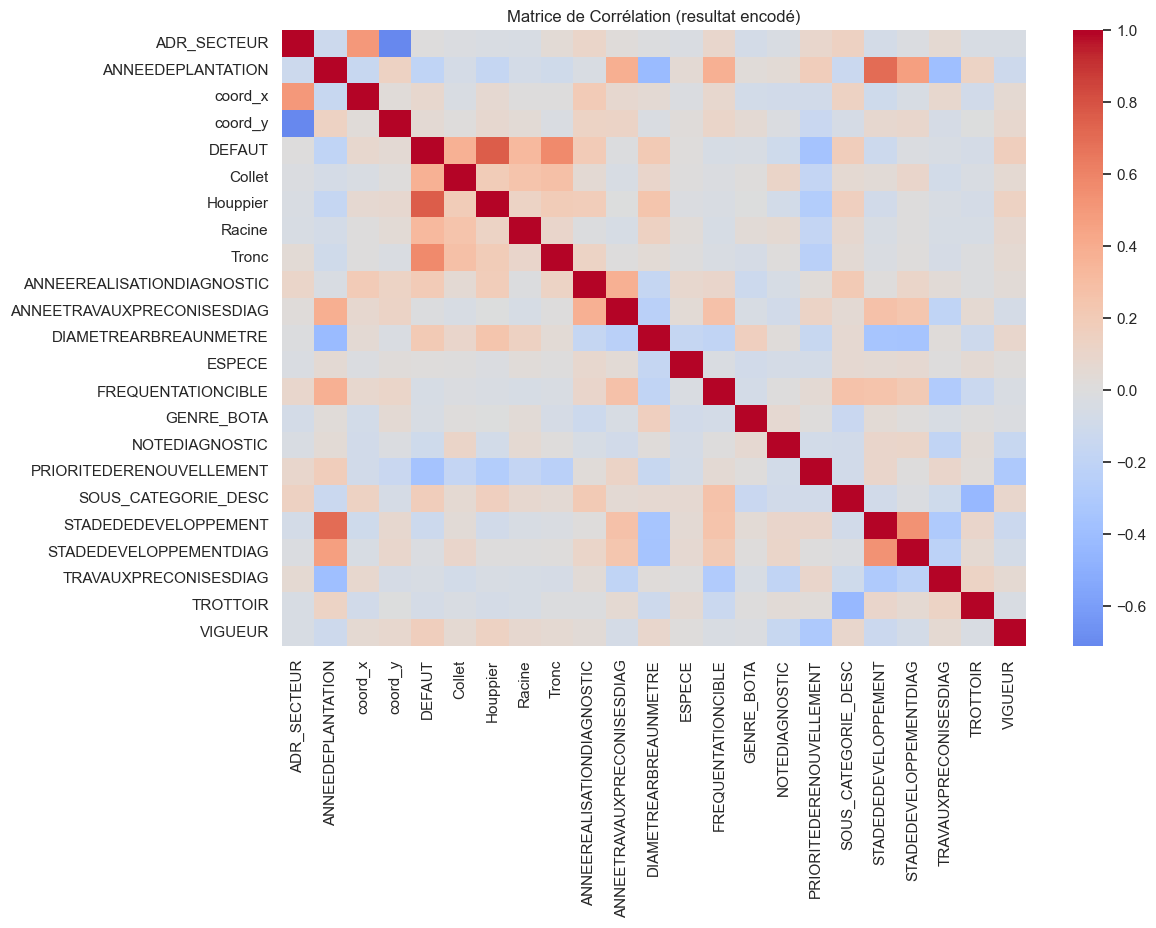

In [11]:
# Cellule 10 — Matrice corr

matrice_corr2 = resultat.corr(numeric_only=True)

plt.figure(figsize=(12, 8))
sns.heatmap(matrice_corr2, cmap='coolwarm', center=0)
plt.title("Matrice de Corrélation (resultat encodé)")
plt.show()


# DÉFI 1 — Tâche 1 : UNI-LABEL (DEFAUT)

In [12]:
# X/y 

TARGETS = ['DEFAUT', 'Collet', 'Houppier', 'Racine', 'Tronc']
targets_present = [t for t in TARGETS if t in data_new.columns]
print("Cibles présentes:", targets_present)

assert 'DEFAUT' in data_new.columns, "Colonne DEFAUT absente."

X_raw = data_new.drop(columns=[t for t in TARGETS if t in data_new.columns])
y_defaut = data_new['DEFAUT'].astype(int)

print("X_raw:", X_raw.shape, "y_defaut:", y_defaut.shape)
print("Distribution DEFAUT:\n", y_defaut.value_counts(normalize=True).round(4))

Cibles présentes: ['DEFAUT', 'Collet', 'Houppier', 'Racine', 'Tronc']
X_raw: (15375, 18) y_defaut: (15375,)
Distribution DEFAUT:
 DEFAUT
0    0.6747
1    0.3253
Name: proportion, dtype: float64


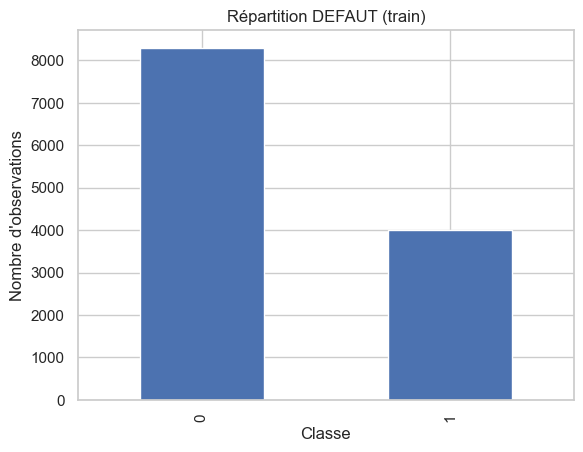

In [13]:
#Split stratifié  + barplot 

X_train, X_test, y_train, y_test = train_test_split(
    X_raw, y_defaut, test_size=0.2, random_state=RANDOM_STATE, stratify=y_defaut
)

y_train.value_counts().plot(kind='bar')
plt.title('Répartition DEFAUT (train)')
plt.xlabel('Classe')
plt.ylabel("Nombre d'observations")
plt.show()

In [14]:
# Prétraitements 
# - OrdinalEncoder pour arbres/RF/XGB
# - OneHot pour LogisticRegression

num_cols = [c for c in X_raw.columns if pd.api.types.is_numeric_dtype(X_raw[c])]
cat_cols = [c for c in X_raw.columns if c not in num_cols]
print("Num:", len(num_cols), "Cat:", len(cat_cols))

preprocess_ordinal = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("enc", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
        ]), cat_cols),
    ],
    remainder="drop"
)

try:
    ohe = OneHotEncoder(handle_unknown="ignore", min_frequency=10, sparse_output=True)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore")

preprocess_onehot = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("ohe", ohe)
        ]), cat_cols),
    ],
    remainder="drop"
)

Num: 4 Cat: 14


In [16]:
# Modèles 

# scale_pos_weight (utile si classe 1 minoritaire)
pos = int(y_train.sum())
neg = int((1 - y_train).sum())
spw = neg / max(pos, 1)

models_uni = {
    "Baseline(MostFreq)": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", DummyClassifier(strategy="most_frequent", random_state=RANDOM_STATE))
    ]),
    "LogReg(OneHot)": Pipeline([
        ("prep", preprocess_onehot),
        ("clf", LogisticRegression(
            random_state=RANDOM_STATE,
            max_iter=5000,
            n_jobs=-1,
            class_weight="balanced",
            solver="saga"
        ))
    ]),
    "DecisionTree": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"))
    ]),
    "RandomForest": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight="balanced_subsample"
        ))
    ]),
    "XGBoost": Pipeline([
        ("prep", preprocess_ordinal),
        ("clf", xgb.XGBClassifier(
            n_estimators=600,
            learning_rate=0.05,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="logloss",
            n_jobs=-1,
            random_state=RANDOM_STATE,
            scale_pos_weight=spw
        ))
    ])
}

def eval_binary(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)

    proba = None
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(Xte)[:, 1]

    out = {
        "accuracy": accuracy_score(yte, pred),
        "balanced_acc": balanced_accuracy_score(yte, pred),
        "precision(1)": precision_score(yte, pred, zero_division=0),
        "recall(1)": recall_score(yte, pred, zero_division=0),
        "f1(1)": f1_score(yte, pred, zero_division=0)
    }
    if proba is not None and len(np.unique(yte)) > 1:
        out["roc_auc"] = roc_auc_score(yte, proba)
        out["avg_precision(AP)"] = average_precision_score(yte, proba)

    return out, pred, proba

rows = []
store_uni = {}

for name, model in models_uni.items():
    m, pred, proba = eval_binary(model, X_train, y_train, X_test, y_test)
    rows.append({"model": name, **m})
    store_uni[name] = (model, pred, proba)

res_uni = pd.DataFrame(rows).sort_values("balanced_acc", ascending=False)
display(res_uni)

,model,accuracy,balanced_acc,precision(1),recall(1),f1(1),roc_auc,avg_precision(AP)
4,XGBoost,0.879675,0.859295,0.824074,0.801,0.812373,0.929931,0.896182
3,RandomForest,0.882276,0.852157,0.856823,0.766,0.808870,0.927526,0.887288
1,LogReg(OneHot),0.837398,0.813982,0.751509,0.747,0.749248,0.885848,0.826779
2,DecisionTree,0.837073,0.807006,0.764581,0.721,0.742151,0.807006,0.641995
0,Baseline(MostFreq),0.674797,0.500000,0.000000,0.000,0.000000,0.500000,0.325203


In [17]:
# Rapport + matrice confusion 

best_name = res_uni.iloc[0]["model"]
best_model, best_pred, best_proba = store_uni[best_name]

print("BEST =", best_name)
print("\nConfusion matrix:\n", confusion_matrix(y_test, best_pred))
print("\nClassification report:\n", classification_report(y_test, best_pred, digits=4))


BEST = XGBoost

Confusion matrix:
 [[1904  171]
 [ 199  801]]

Classification report:
               precision    recall  f1-score   support

           0     0.9054    0.9176    0.9114      2075
           1     0.8241    0.8010    0.8124      1000

    accuracy                         0.8797      3075
   macro avg     0.8647    0.8593    0.8619      3075
weighted avg     0.8789    0.8797    0.8792      3075



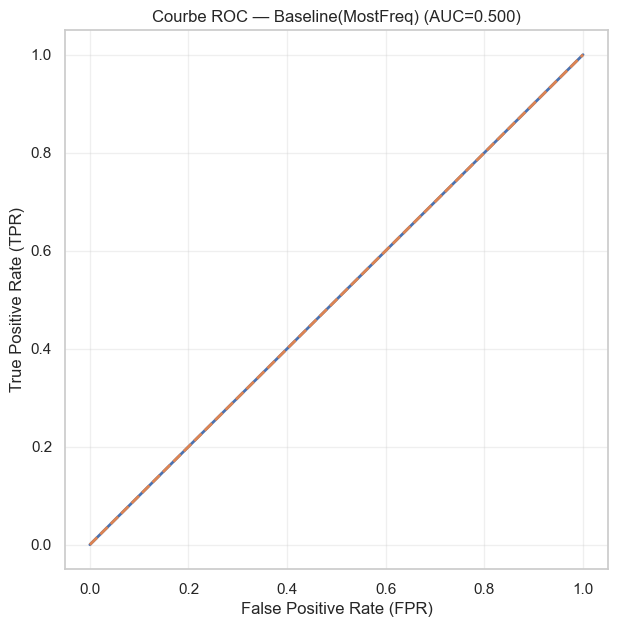

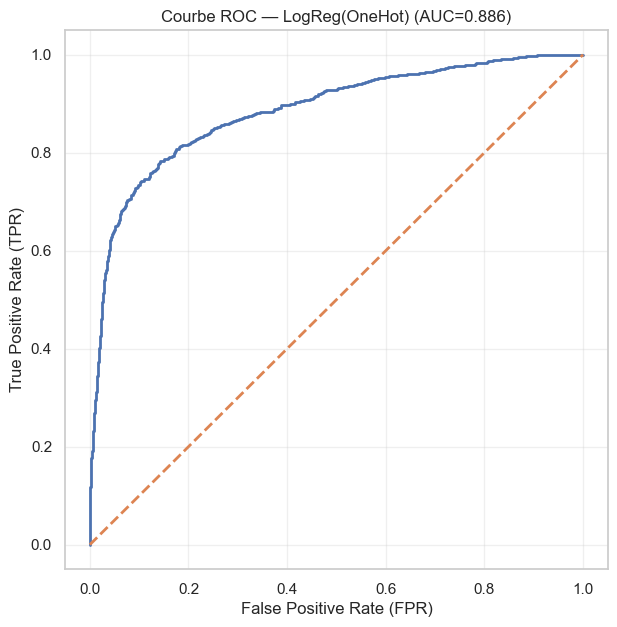

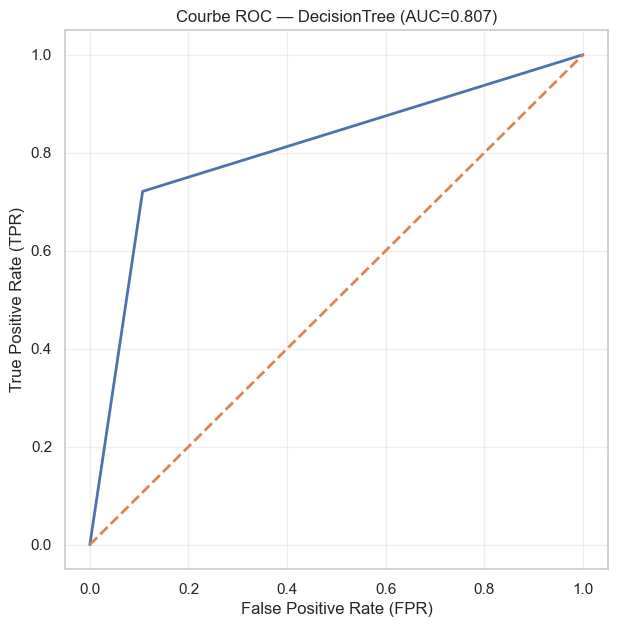

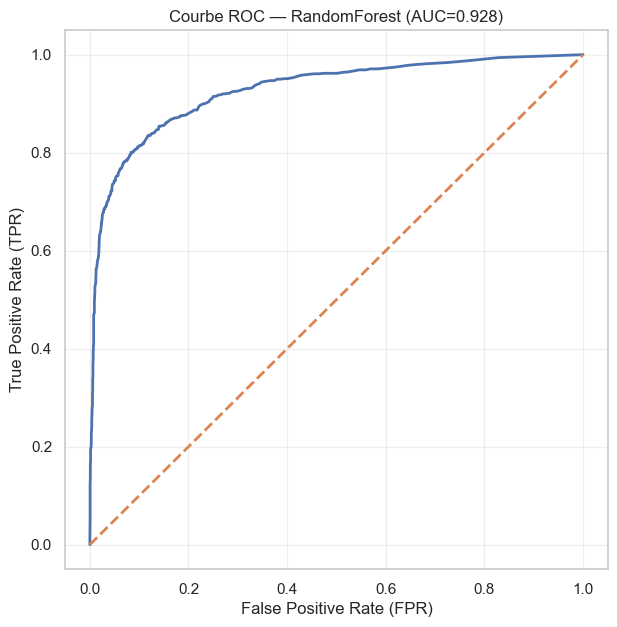

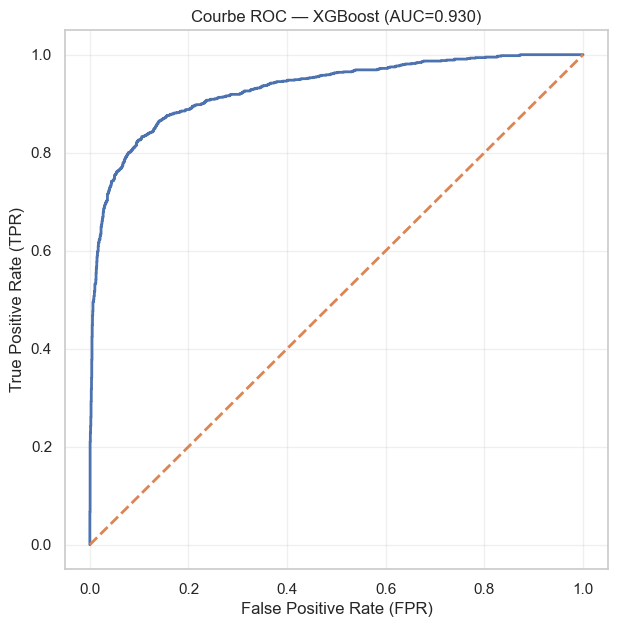

In [22]:
# Cellule 16 — ROC "une figure par modèle" 

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

if len(np.unique(y_test)) < 2:
    print("ROC impossible: y_test ne contient qu'une seule classe.")
else:
    for name, model in models_uni.items():
        # Fit sur train uniquement
        model.fit(X_train, y_train)

        # Score pour ROC
        y_score = None
        if hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X_test)[:, 1]
        elif hasattr(model, "decision_function"):
            y_score = model.decision_function(X_test)
        else:
            print(f"[WARN] {name} : ni predict_proba ni decision_function -> ROC non tracée.")
            continue

        fpr, tpr, _ = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(7, 7))
        plt.plot(fpr, tpr, lw=2)
        plt.plot([0, 1], [0, 1], lw=2, linestyle="--")
        plt.xlabel("False Positive Rate (FPR)")
        plt.ylabel("True Positive Rate (TPR)")
        plt.title(f"Courbe ROC — {name} (AUC={roc_auc:.3f})")
        plt.grid(True, alpha=0.3)
        plt.show()


In [19]:
# Validation croisée 

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "acc": "accuracy",
    "bal_acc": "balanced_accuracy",
    "precision": "precision",
    "recall": "recall",
    "f1": "f1",
    "roc_auc": "roc_auc",
    "ap": "average_precision"
}

cv_rows = []
for name, model in models_uni.items():
    out = cross_validate(model, X_raw, y_defaut, cv=cv, scoring=scoring, n_jobs=-1)
    row = {"model": name}
    for k in scoring:
        row[k] = float(np.mean(out["test_" + k]))
    cv_rows.append(row)

cv_uni = pd.DataFrame(cv_rows).sort_values("bal_acc", ascending=False)
display(cv_uni)

,model,acc,bal_acc,precision,recall,f1,roc_auc,ap
4,XGBoost,0.873041,0.857660,0.799621,0.813641,0.806456,0.928123,0.887966
3,RandomForest,0.877463,0.847939,0.844903,0.763452,0.801975,0.925733,0.880804
1,LogReg(OneHot),0.835642,0.814875,0.743457,0.755448,0.749340,0.886966,0.821088
2,DecisionTree,0.837008,0.812315,0.753457,0.741653,0.747429,0.812315,0.642844
0,Baseline(MostFreq),0.674732,0.500000,0.000000,0.000000,0.000000,0.500000,0.325268


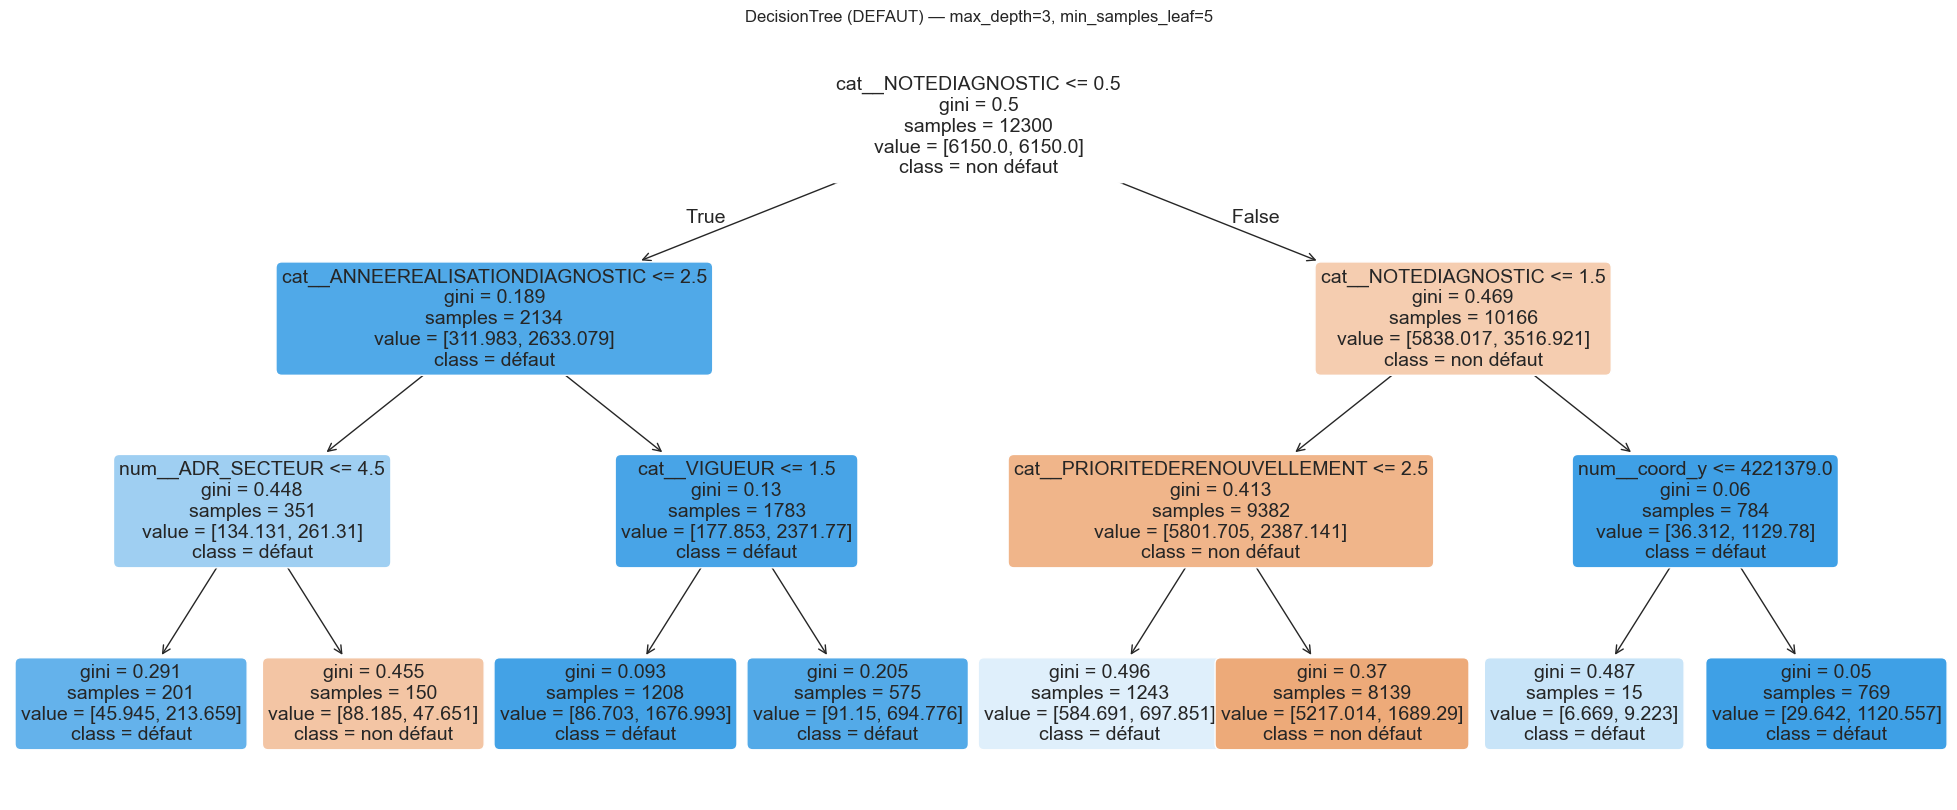

In [ ]:
# Arbre de décision  

from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier, plot_tree
import numpy as np
import matplotlib.pyplot as plt

# 1) Prétraitement : fit sur train uniquement
prep = clone(preprocess_ordinal)
X_train_tr = prep.fit_transform(X_train)
X_test_tr  = prep.transform(X_test)

# Si jamais c'est sparse, on convertit pour plot_tree
try:
    import scipy.sparse as sp
    if sp.issparse(X_train_tr):
        X_train_tr = X_train_tr.toarray()
except Exception:
    pass

# 2) Récupérer les noms de features après ColumnTransformer
try:
    feature_names = prep.get_feature_names_out()
except Exception:
    # Fallback (sklearn ancien) : au moins des noms lisibles
    feature_names = np.array([*num_cols, *cat_cols], dtype=object)

# 3) Arbre court et lisible 
tree = DecisionTreeClassifier(
    criterion="gini",
    random_state=100,
    max_depth=3,
    min_samples_leaf=5,
    class_weight="balanced"
)
tree.fit(X_train_tr, y_train)

# 4) Class names (ordre = tree.classes_ généralement [0,1])
name_map = {0: "non défaut", 1: "défaut"}
class_names = [name_map.get(int(c), str(c)) for c in tree.classes_]

plt.figure(figsize=(25, 10))
a = plot_tree(
    tree,
    feature_names=feature_names,
    class_names=class_names,
    filled=True,
    rounded=True,
    fontsize=14
)
plt.title("DecisionTree (DEFAUT) — max_depth=3, min_samples_leaf=5")
plt.show()


# DÉFI 1 — Tâche 2 : MULTI-LABEL (Collet/Houppier/Racine/Tronc)

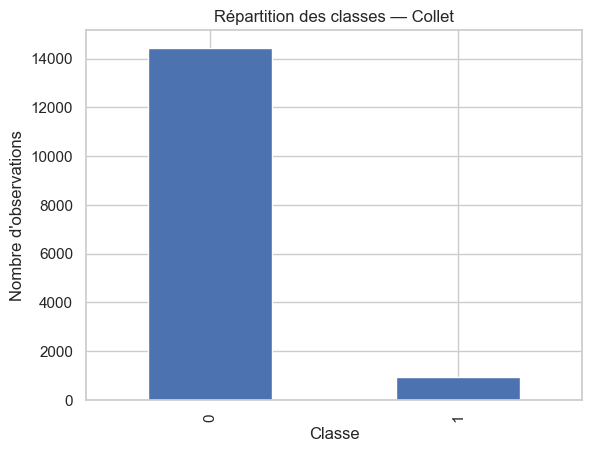

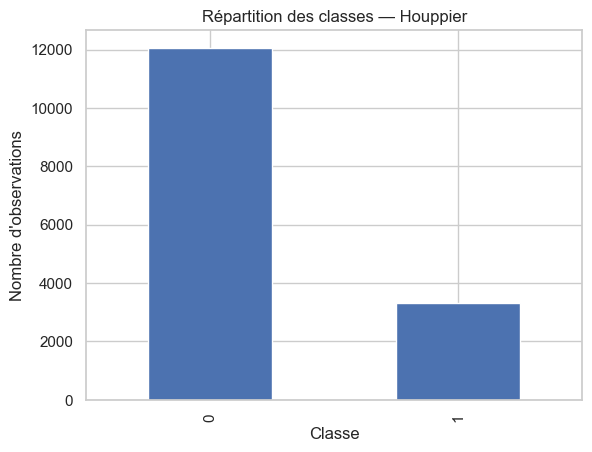

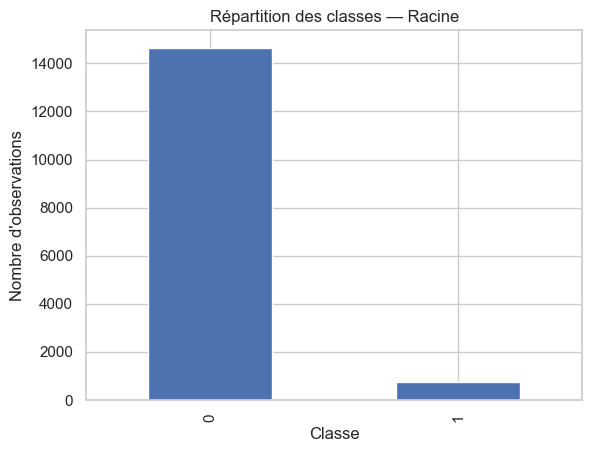

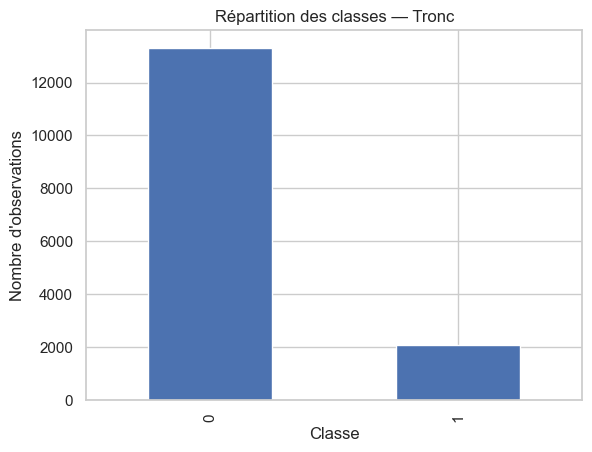

In [23]:
# Y multi-label + distributions 

label_cols = [c for c in ['Collet', 'Houppier', 'Racine', 'Tronc'] if c in data_new.columns]
assert len(label_cols) == 4, f"Labels attendus manquants. Présents: {label_cols}"

Y_multi = data_new[label_cols].astype(int)

for c in label_cols:
    data_new[c].value_counts().plot(kind="bar")
    plt.title(f"Répartition des classes — {c}")
    plt.xlabel("Classe")
    plt.ylabel("Nombre d'observations")
    plt.show()

In [24]:
# Split multi-label 

strat = Y_multi.sum(axis=1)

X_train_m, X_test_m, Y_train_m, Y_test_m = train_test_split(
    X_raw, Y_multi, test_size=0.2, random_state=RANDOM_STATE, stratify=strat
)

print("Train:", X_train_m.shape, "Test:", X_test_m.shape)
print("Distrib nb labels (train):\n", Y_train_m.sum(axis=1).value_counts().sort_index())
print("Distrib nb labels (test):\n", Y_test_m.sum(axis=1).value_counts().sort_index())


Train: (12300, 18) Test: (3075, 18)
Distrib nb labels (train):
 0    8299
1    2800
2     838
3     307
4      56
Name: count, dtype: int64
Distrib nb labels (test):
 0    2075
1     700
2     209
3      77
4      14
Name: count, dtype: int64


In [25]:
# Fonction d'undersampling 

rus = RandomUnderSampler(random_state=RANDOM_STATE)

def undersample_on_train(Xtr, ytr):
    Xr, yr = rus.fit_resample(Xtr, ytr)
    return Xr, yr

In [ ]:
# Modèles 

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

def build_models_bin():
    return {
        "Régression Logistique": Pipeline([
            ("prep", preprocess_onehot),
            ("clf", LogisticRegression(
                random_state=RANDOM_STATE,
                max_iter=5000,
                n_jobs=-1,
                class_weight="balanced",
                solver="saga"
            ))
        ]),
        "Random Forest": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", RandomForestClassifier(
                n_estimators=400,
                random_state=RANDOM_STATE,
                n_jobs=-1,
                class_weight="balanced_subsample"
            ))
        ]),
        "XGBoost": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", xgb.XGBClassifier(
                n_estimators=600,
                learning_rate=0.05,
                max_depth=6,
                subsample=0.8,
                colsample_bytree=0.8,
                reg_lambda=1.0,
                objective="binary:logistic",
                eval_metric="logloss",
                n_jobs=-1,
                random_state=RANDOM_STATE,
                # on undersample => données ~ équilibrées => spw ~ 1
                scale_pos_weight=1.0
            ))
        ]),
        "Arbre de décision": Pipeline([
            ("prep", preprocess_ordinal),
            ("clf", DecisionTreeClassifier(
                random_state=RANDOM_STATE,
                class_weight="balanced",
                max_depth=6
            ))
        ]),
    }

In [28]:
# Micro: 1 tableau par label (Accuracy/Précision/Rappel/AUC + CrossVal K=10)
# + stockage des probas pour tracer ROC ensuite

from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def eval_label_once(model, Xtr, ytr, Xte, yte):
    model.fit(Xtr, ytr)
    pred = model.predict(Xte)
    proba = model.predict_proba(Xte)[:, 1] if hasattr(model, "predict_proba") else None

    out = {
        "Accuracy": accuracy_score(yte, pred),
        "Précision": precision_score(yte, pred, zero_division=0),
        "Rappel": recall_score(yte, pred, zero_division=0),
        "F1": f1_score(yte, pred, zero_division=0),
    }
    if proba is not None and len(np.unique(yte)) > 1:
        out["AUC"] = roc_auc_score(yte, proba)
    else:
        out["AUC"] = np.nan

    return out, pred, proba

cv10 = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
scoring_cv = {"acc": "accuracy", "auc": "roc_auc"}

micro_tables = {}      # label -> DataFrame résultats
proba_store = {}       # (label, modelname) -> proba sur test

for lab in label_cols:
    print(f"\n==================== {lab} ====================")

    ytr = Y_train_m[lab].astype(int)
    yte = Y_test_m[lab].astype(int)

    # undersampling sur TRAIN uniquement 
    Xr, yr = undersample_on_train(X_train_m, ytr)

    print("Avant undersampling:", ytr.value_counts().to_dict())
    print("Après  undersampling:", pd.Series(yr).value_counts().to_dict())

    rows = []
    models_bin = build_models_bin()

    for mname, model in models_bin.items():
        # Cross-val K=10 sur le TRAIN rééquilibré 
        cv_out = cross_validate(model, Xr, yr, cv=cv10, scoring=scoring_cv, n_jobs=-1)
        cv_acc = float(np.mean(cv_out["test_acc"]))
        cv_auc = float(np.mean(cv_out["test_auc"]))

        # Éval test
        metrics, pred, proba = eval_label_once(model, Xr, yr, X_test_m, yte)

        rows.append({
            "Modèle": mname,
            "Accuracy": metrics["Accuracy"],
            "Précision": metrics["Précision"],
            "Rappel": metrics["Rappel"],
            "Score AUC": metrics["AUC"],
            "Cross Val Acc (K=10)": cv_acc,
            "Cross Val AUC (K=10)": cv_auc
        })

        if proba is not None:
            proba_store[(lab, mname)] = proba

    df_lab = pd.DataFrame(rows)

    pct_cols = ["Accuracy", "Précision", "Rappel", "Score AUC", "Cross Val Acc (K=10)", "Cross Val AUC (K=10)"]
    for c in pct_cols:
        df_lab[c] = (df_lab[c] * 100).round(2)

    micro_tables[lab] = df_lab
    display(df_lab)


==================== Collet ====================
Avant undersampling: {0: 11552, 1: 748}
Après  undersampling: {0: 748, 1: 748}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,76.94,17.00,75.14,83.83,77.20,84.79
1,Random Forest,79.19,19.44,80.66,87.43,79.54,87.39
2,XGBoost,78.83,19.56,83.43,87.46,79.07,86.38
3,Arbre de décision,80.91,19.61,72.38,83.58,75.06,80.97



==================== Houppier ====================
Avant undersampling: {0: 9641, 1: 2659}
Après  undersampling: {0: 2659, 1: 2659}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,83.84,58.45,83.84,90.09,82.57,89.01
1,Random Forest,84.88,60.21,85.82,92.88,84.02,91.48
2,XGBoost,85.59,61.66,85.82,93.27,84.26,91.96
3,Arbre de décision,83.19,57.89,77.74,87.86,80.63,86.01



==================== Racine ====================
Avant undersampling: {0: 11713, 1: 587}
Après  undersampling: {0: 587, 1: 587}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,76.13,12.61,74.81,83.20,76.42,84.22
1,Random Forest,79.84,16.37,87.41,89.85,80.25,87.94
2,XGBoost,78.96,15.59,85.93,88.98,79.57,87.78
3,Arbre de décision,76.29,13.24,79.26,81.41,72.50,76.27



==================== Tronc ====================
Avant undersampling: {0: 10673, 1: 1627}
Après  undersampling: {0: 1627, 1: 1627}


,Modèle,Accuracy,Précision,Rappel,Score AUC,Cross Val Acc (K=10),Cross Val AUC (K=10)
0,Régression Logistique,80.91,39.84,69.75,82.07,77.75,84.37
1,Random Forest,78.57,37.39,77.37,85.54,80.27,86.94
2,XGBoost,79.87,39.36,79.45,85.83,79.16,86.69
3,Arbre de décision,83.45,44.24,67.44,81.92,78.18,83.06



==== Courbes ROC (2x2) — Collet ====


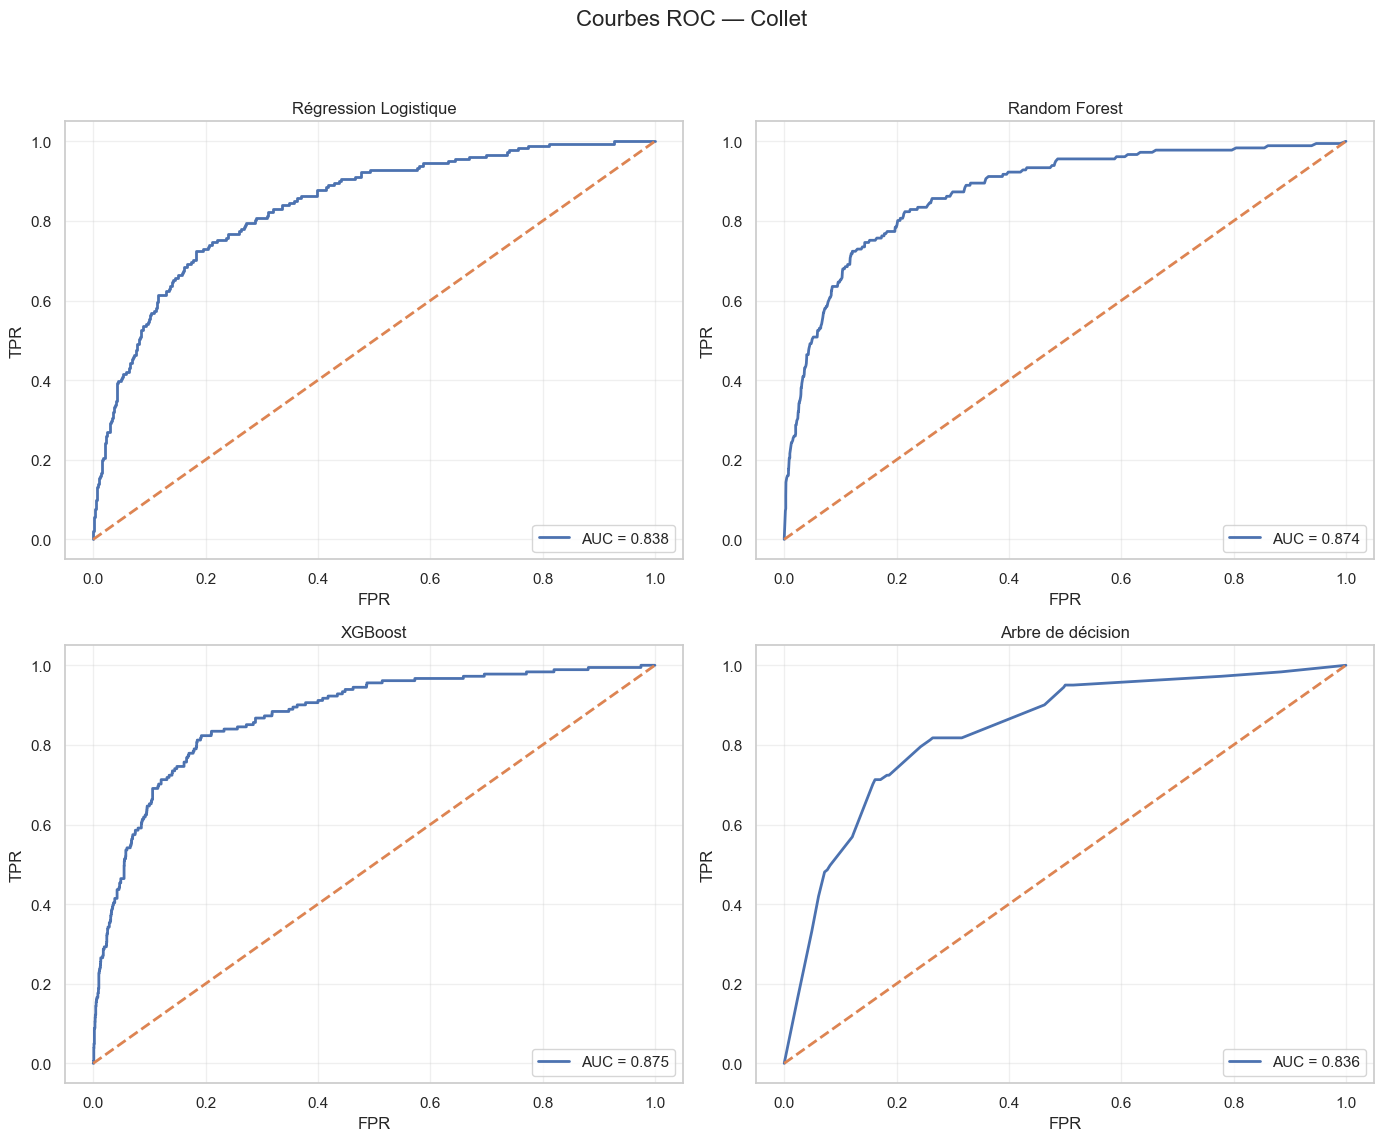


==== Courbes ROC (2x2) — Houppier ====


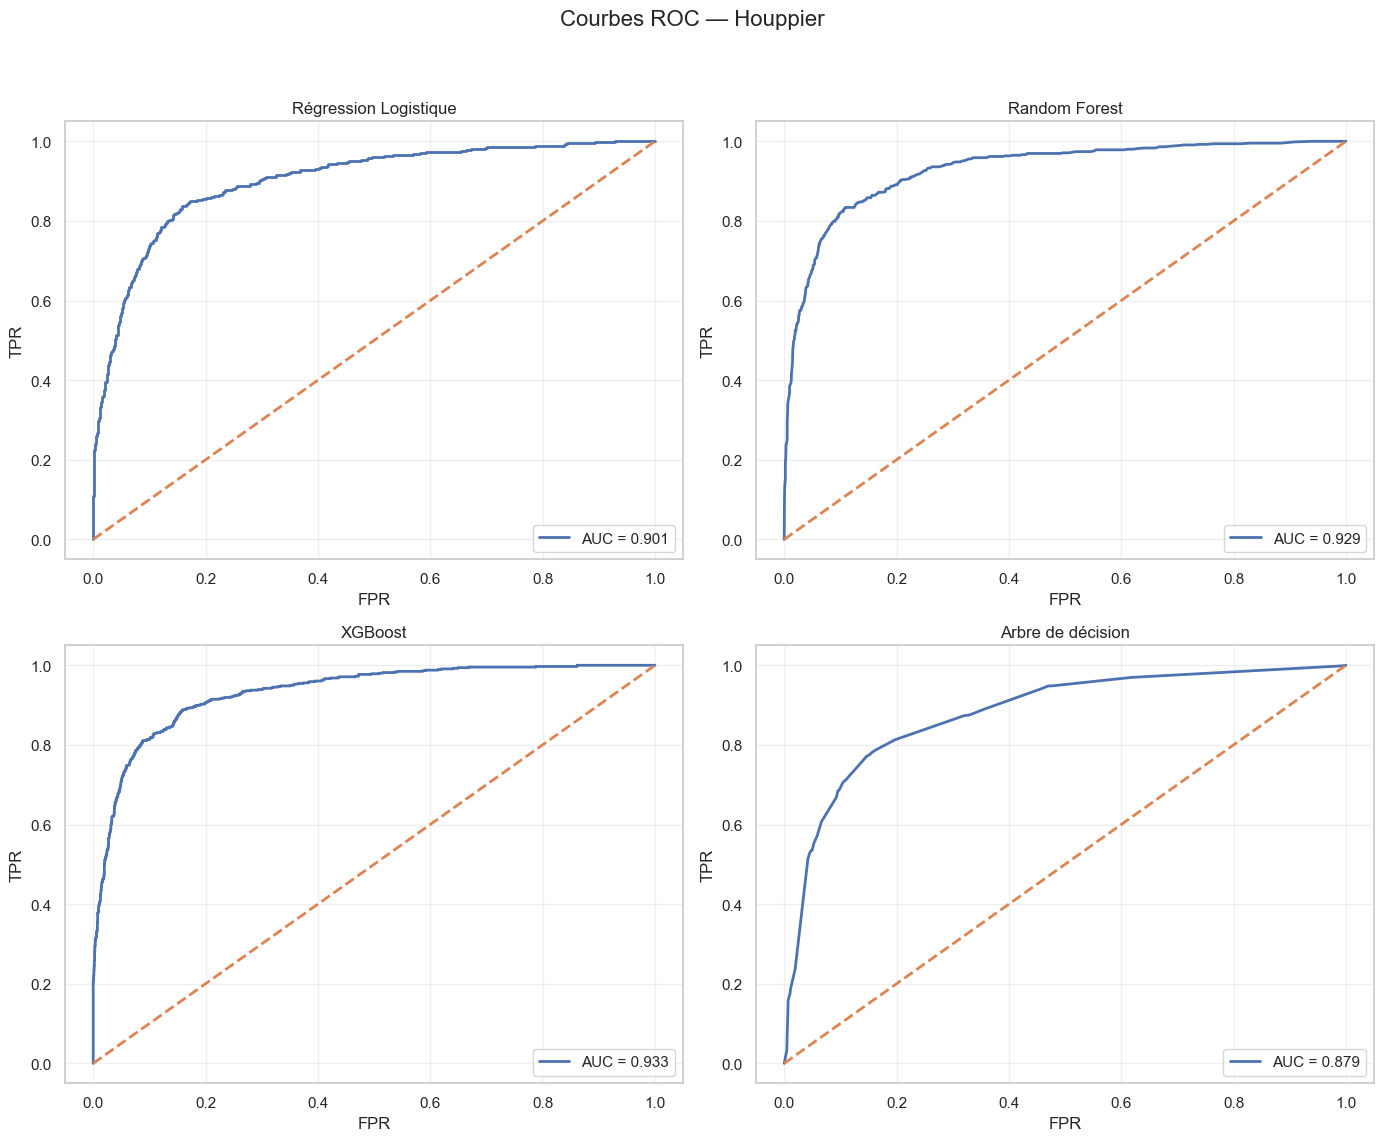


==== Courbes ROC (2x2) — Racine ====


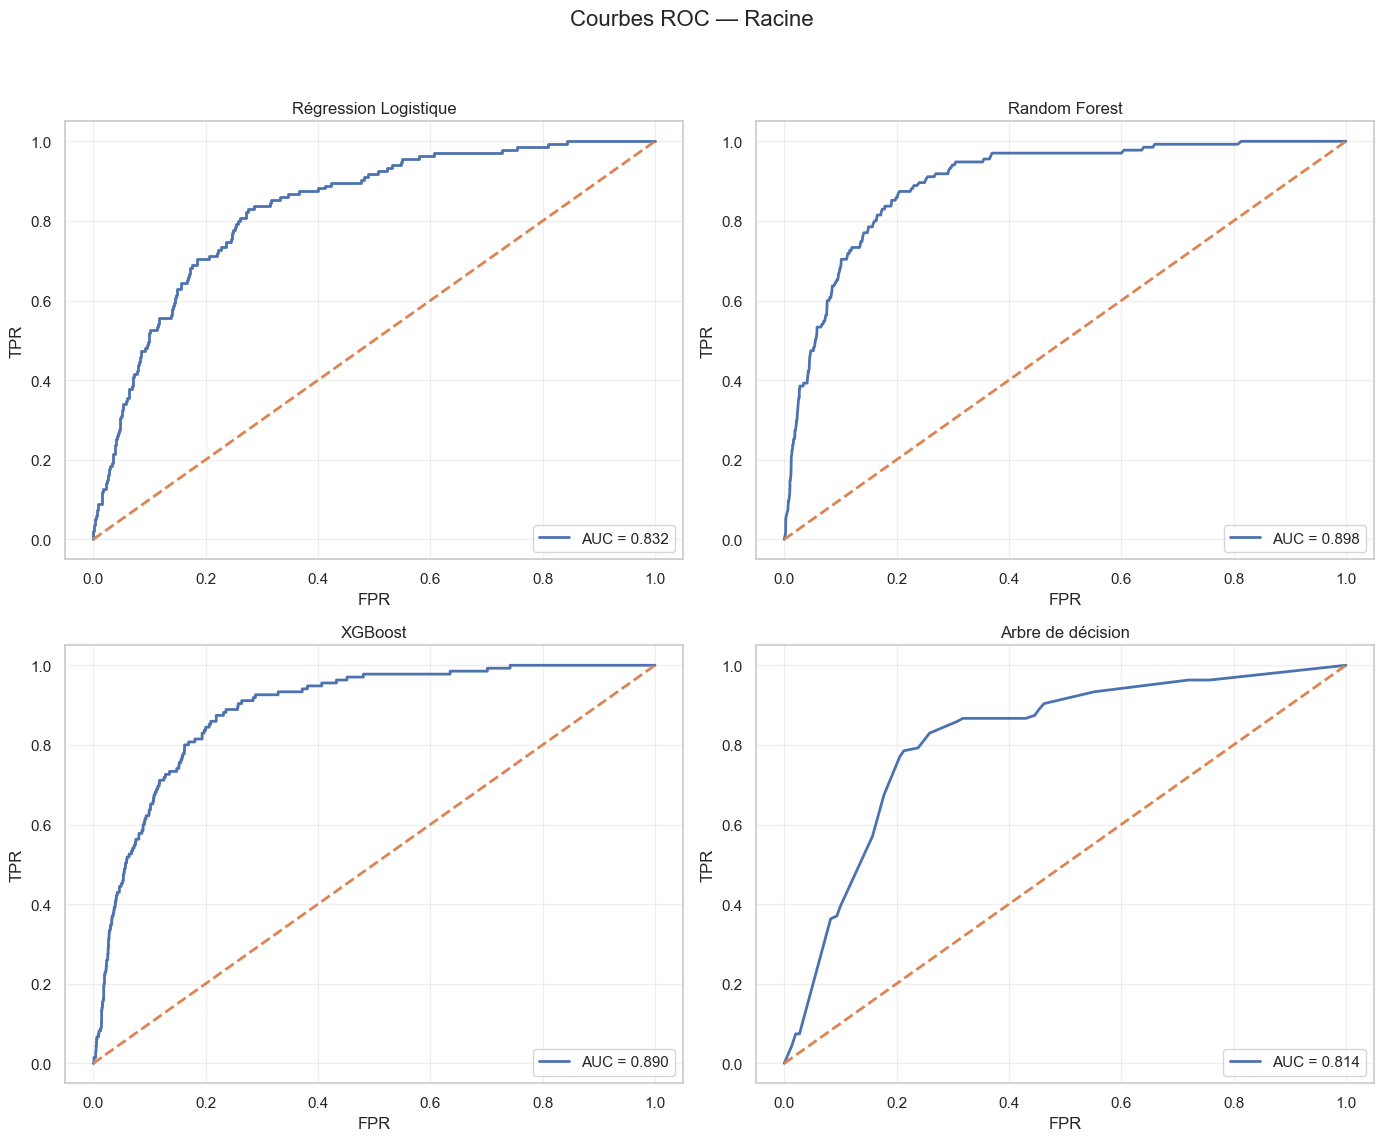


==== Courbes ROC (2x2) — Tronc ====


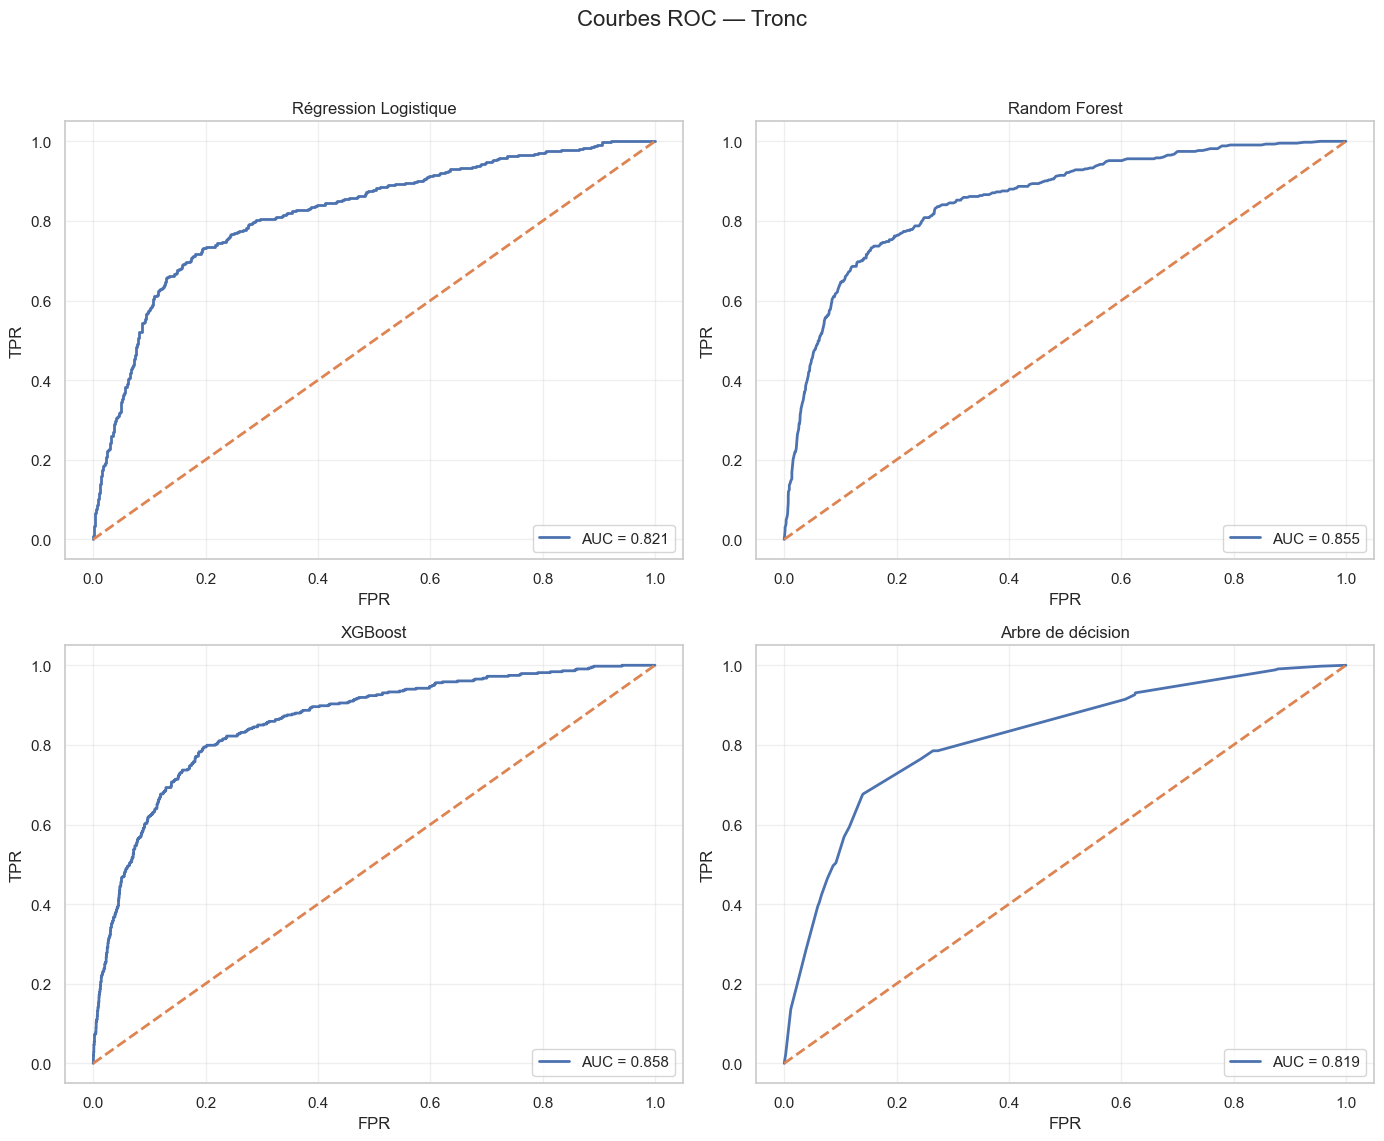

In [30]:
# Courbes ROC 
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models_order = ["Régression Logistique", "Random Forest", "XGBoost", "Arbre de décision"]

for lab in label_cols:
    print(f"\n==== Courbes ROC (2x2) — {lab} ====")

    y_true = Y_test_m[lab].astype(int).values
    if len(np.unique(y_true)) < 2:
        print(f"ROC impossible pour {lab} : y_test ne contient qu'une seule classe.")
        continue

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))
    axes = axes.ravel()

    for i, mname in enumerate(models_order):
        ax = axes[i]
        proba = proba_store.get((lab, mname), None)

        if proba is None:
            ax.set_title(f"{mname}\n[probas manquantes]")
            ax.axis("off")
            continue

        fpr, tpr, _ = roc_curve(y_true, proba)
        roc_auc = auc(fpr, tpr)

        ax.plot(fpr, tpr, lw=2, label=f"AUC = {roc_auc:.3f}")
        ax.plot([0, 1], [0, 1], lw=2, linestyle="--")
        ax.set_xlabel("FPR")
        ax.set_ylabel("TPR")
        ax.set_title(f"{mname}")
        ax.grid(True, alpha=0.3)
        ax.legend(loc="lower right")

    fig.suptitle(f"Courbes ROC — {lab}", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


In [31]:
# Macro : moyenne sur les 4 labels, par modèle
# (ici on moyenne Accuracy/Précision/Rappel/AUC sur Collet/Houppier/Racine/Tronc)

all_micro = pd.concat([micro_tables[lab].assign(Label=lab) for lab in label_cols], ignore_index=True)

macro = (all_micro
         .groupby("Modèle")[["Accuracy","Précision","Rappel","Score AUC"]]
         .mean()
         .round(2)
         .reset_index()
         .sort_values("Score AUC", ascending=False))

display(macro)

,Modèle,Accuracy,Précision,Rappel,Score AUC
1,Random Forest,80.62,33.35,82.82,88.92
3,XGBoost,80.81,34.04,83.66,88.88
2,Régression Logistique,79.46,31.98,75.89,84.80
0,Arbre de décision,80.96,33.75,74.20,83.69


In [32]:
# Métriques globales multi-label avec le "meilleur modèle" macro
# -> construit Y_hat complet (un classifieur par label) puis subset accuracy + hamming + micro/macro F1

from sklearn.metrics import accuracy_score, hamming_loss, precision_score, recall_score, f1_score

best_algo = macro.iloc[0]["Modèle"]
print("Meilleur modèle (macro):", best_algo)

Y_pred_hat = pd.DataFrame(index=Y_test_m.index)

for lab in label_cols:
    ytr = Y_train_m[lab].astype(int)
    Xr, yr = undersample_on_train(X_train_m, ytr)

    model = build_models_bin()[best_algo]
    model.fit(Xr, yr)
    Y_pred_hat[lab] = model.predict(X_test_m)

Y_true = Y_test_m.values
Y_hat = Y_pred_hat.values

print("Subset accuracy (exact match):", accuracy_score(Y_true, Y_hat))
print("Hamming loss:", hamming_loss(Y_true, Y_hat))
print("Micro F1:", f1_score(Y_true, Y_hat, average="micro", zero_division=0))
print("Macro F1:", f1_score(Y_true, Y_hat, average="macro", zero_division=0))


Meilleur modèle (macro): Random Forest
Subset accuracy (exact match): 0.527479674796748
Hamming loss: 0.1938211382113821
Micro F1: 0.49362786745964315
Macro F1: 0.4502187730931535
